<a href="https://colab.research.google.com/github/mrazimi99/deep-packet/blob/main/DeepPacket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !apt install axel
# !apt install dtrx
# !apt install tshark

In [3]:
!pip install scapy

In [4]:
from pathlib import Path
import os
import os.path
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scapy.utils import rdpcap, PcapReader
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

import time
from datetime import timedelta
from datetime import datetime
import pickle

import sys
sys.path.append('drive/MyDrive/deep_packet')
from utils import should_omit_packet, PREFIX_TO_APP_ID, PREFIX_TO_TRAFFIC_ID, ID_TO_APP, ID_TO_TRAFFIC

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def remove_ether_header(packet):
    if Ether in packet:
        return packet[Ether].payload

    return packet


def mask_ip(packet):
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'

    return packet


def pad_udp(packet):
    if UDP in packet:
        # get layers after udp
        layer_after = packet[UDP].payload.copy()

        # build a padding layer
        pad = Padding()
        pad.load = '\x00' * 12

        layer_before = packet.copy()
        layer_before[UDP].remove_payload()
        packet = layer_before / pad / layer_after

        return packet

    return packet


def packet_to_sparse_array(packet, max_length=1500):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length]     # Divide to 255 later
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    packet = remove_ether_header(packet)
    packet = pad_udp(packet)
    packet = mask_ip(packet)

    arr = packet_to_sparse_array(packet)

    return arr

pcaps = 'drive/MyDrive/deep_packet/Pcaps/vpn/'
cache = 'drive/MyDrive/deep_packet/Dataset/vpn_dataset.pickle'
dataset = []

# if not os.path.isfile(cache):
if False:
    for path in os.listdir(pcaps):
        print('Processing ' + path)
        for i, packet in enumerate(rdpcap(pcaps + path)):
            arr = transform_packet(packet)
            if arr is not None:
                # get labels for app identification
                prefix = path.split('.')[0].lower()
                app_label = PREFIX_TO_APP_ID.get(prefix)
                traffic_label = PREFIX_TO_TRAFFIC_ID.get(prefix)
                row = {
                    'app_label': app_label,
                    'traffic_label': traffic_label,
                    'feature': arr.todense().tolist()[0]
                }
                dataset.append(row)
    
    with open(cache, 'wb') as f:
        pickle.dump(dataset, f)
else:
    dataset = []
    data_dir = 'drive/MyDrive/deep_packet/Dataset/'
    for path in os.listdir(data_dir):
        with open(data_dir + path, 'rb') as f:
            dataset.extend(pickle.load(f))

In [6]:
# traffic_labels = [row['traffic_label'] for row in dataset]
app_labels = [row['app_label'] for row in dataset]
# traffic_classes = set(traffic_labels)
app_classes = set(app_labels)

# traffic_train_all, traffic_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=traffic_labels)
app_train_all, app_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=app_labels)

del dataset

In [7]:
# undersample = RandomUnderSampler(sampling_strategy='majority')
# traffic_features = [elem['feature'] for elem in traffic_train_all]
# train_traffic_labels = [elem['traffic_label'] for elem in traffic_train_all]
# traffic_train, traffic_y = undersample.fit_resample(traffic_features, train_traffic_labels)
# del traffic_features, train_traffic_labels, traffic_train_all

undersample = RandomUnderSampler(sampling_strategy='majority')
app_features = [elem['feature'] for elem in app_train_all]
train_app_labels = [elem['app_label'] for elem in app_train_all]
app_train, app_y = undersample.fit_resample(app_features, train_app_labels)
del app_features, train_app_labels, app_train_all

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
# traffic_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in f.tolist()], dtype=np.float32)), 'label': l} for f, l in zip(traffic_train, traffic_y)]
# del traffic_train, traffic_y
app_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in f.tolist()], dtype=np.float32)), 'label': l} for f, l in zip(app_train, app_y)]
del app_train, app_y

# traffic_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['traffic_label']} for elem in traffic_test_all]
# del traffic_test_all
app_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['app_label']} for elem in app_test_all]
del app_test_all

In [9]:
batch_size = 64
num_workers = 2
import random
# random.shuffle(traffic_train_final)
random.shuffle(app_train_final)
# traffic_train_loader = torch.utils.data.DataLoader(traffic_train_final, batch_size=batch_size, num_workers=num_workers)
app_train_loader = torch.utils.data.DataLoader(app_train_final, batch_size=batch_size, num_workers=num_workers)
# traffic_test_loader = torch.utils.data.DataLoader(traffic_test_final, batch_size=batch_size, num_workers=num_workers)
app_test_loader = torch.utils.data.DataLoader(app_test_final, batch_size=batch_size, num_workers=num_workers)

In [10]:
class Model(nn.Module):
    def __init__(self, input_num, middle_layers, output_num, act):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.acts = []

        self.layers.append(nn.Linear(input_num, middle_layers[0]))
        self.acts.append(act)

        for i in range(len(middle_layers) - 1):
            self.layers.append(nn.Linear(middle_layers[i], middle_layers[i + 1]))
            self.acts.append(act)

        self.layers.append(nn.Linear(middle_layers[-1], output_num))

    def forward(self, x):

        x = x.view(x.size(0), -1)

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.acts[i](x)

        x = self.layers[-1](x)
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
    total_time = 0.
    loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()

        for elem in train_loader:
            byte_array = elem['feature'].to(device)
            labels = elem['label'].to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(byte_array)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        loss_per_epoch[epoch + 1] = average_loss
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))

    if math.isnan(max(loss_per_epoch.values())):
        print('Could not plot for nan losses.')
    else:
        plt.plot(list(loss_per_epoch.keys()), list(loss_per_epoch.values()))
        plt.title('Avreage Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Aerage Loss')
        plt.xlim(1, num_epochs + 1)
        plt.ylim(0, max(loss_per_epoch.values()) + 1)
        plt.show()

    print('total training time: %.3f minutes' % (total_time / 60))

In [13]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}
    all_predicted = {id : 0 for id in range(len(classes))}

    # Iterate through test dataset
    with torch.no_grad():
      for elem in test_loader:
        byte_array = elem['feature'].to(device)
        labels = elem['label']
        outputs = model(byte_array)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1
            pc = p.to('cpu').item()
            all_predicted[pc] += 1

            if p == l:
                correct_predicted[pc] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return [x / y if y else 0 for x, y in zip(correct_predicted.values(), all_predicted.values())], [x / y if y else 0 for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [14]:
def analyse(model, train_loader, test_loader, classes):
    print('Train ', end='')
    train_rcs, train_prs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    test_rcs, test_prs = test_model_accuracy(model, test_loader, classes)
    test_f1 = []

    print('Class\tRc\tPr\tF1')
    for i, (rc, pr) in enumerate(zip(test_rcs, test_prs)):
        f1 = 2 * rc * pr / (rc + pr) if (rc + pr) else 0
        test_f1.append(f1)
        print(str(i) + '\t' + str(round(rc, 2)) + '\t' + str(round(pr, 2)) + '\t' + str(round(f1, 2)))
    print('Avg\t' + str(round(sum(test_rcs) / len(test_rcs))) + '\t' + str(round(sum(test_prs) / len(test_prs))) + '\t' + str(round(sum(test_f1) / len(test_f1))))

    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_prs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_prs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), classes, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

In [15]:
input_vector = 1500

# output_len = max(traffic_classes) + 1
output_len = max(app_classes) + 1

model = Model(input_vector, [200, 100, 50] , output_len, F.relu)
model = model.to(device)

learning_rate = 0.05
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# print(traffic_classes)
print(app_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16}


epoch 1, train_loss: 1.451, time elapsed: 11.566765 seconds
epoch 2, train_loss: 0.530, time elapsed: 11.136521 seconds
epoch 3, train_loss: 0.304, time elapsed: 10.91869 seconds
epoch 4, train_loss: 0.289, time elapsed: 11.023295 seconds
epoch 5, train_loss: 0.223, time elapsed: 11.137987 seconds
epoch 6, train_loss: 0.190, time elapsed: 10.983711 seconds
epoch 7, train_loss: 0.162, time elapsed: 11.067984 seconds
epoch 8, train_loss: 0.185, time elapsed: 10.971045 seconds
epoch 9, train_loss: 0.149, time elapsed: 10.973469 seconds
epoch 10, train_loss: 0.136, time elapsed: 11.298604 seconds
epoch 11, train_loss: 0.128, time elapsed: 10.938595 seconds
epoch 12, train_loss: 0.111, time elapsed: 10.838002 seconds
epoch 13, train_loss: 0.114, time elapsed: 10.810298 seconds
epoch 14, train_loss: 0.092, time elapsed: 11.05622 seconds
epoch 15, train_loss: 0.118, time elapsed: 11.206305 seconds
epoch 16, train_loss: 0.098, time elapsed: 11.060811 seconds
epoch 17, train_loss: 0.079, time e

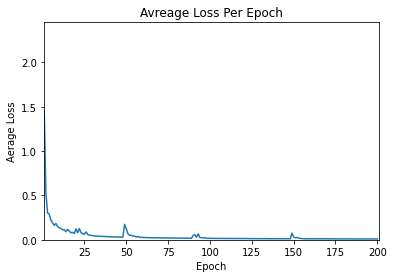

total training time: 36.414 minutes


In [18]:
# fit(model, traffic_train_loader, device, criterion, optimizer, num_epochs=200)
fit(model, app_train_loader, device, criterion, optimizer, num_epochs=200)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Train Accuracy: 99.5091242927268%
Test Accuracy: 97.76634236552223%
Class	Rc	Pr	F1
0	0.96	0.97	0.96
1	0.95	0.94	0.95
2	0.99	1.0	0.99
3	0.98	0.95	0.97
4	0	0	0
5	0.96	0.98	0.97
6	0.97	0.98	0.98
7	0.99	0.99	0.99
8	0.97	0.99	0.98
9	0.99	1.0	1.0
10	0.99	1.0	1.0
11	0.98	0.99	0.99
Avg	1	1	1


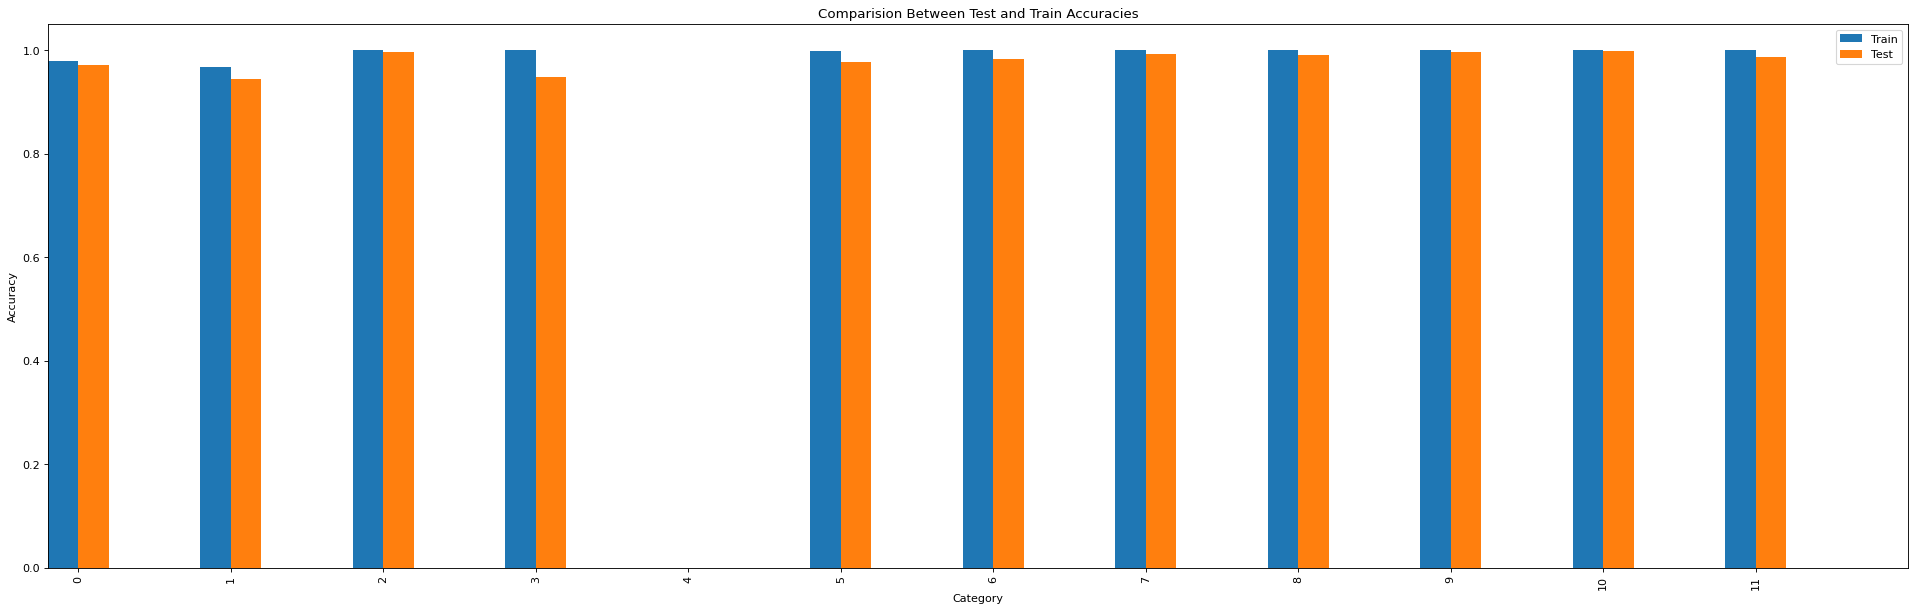

In [39]:
classes = [i for i in range(max(traffic_classes) + 1)]
print(classes)
analyse(model, traffic_train_loader, traffic_test_loader, classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Train Accuracy: 99.73957528701894%
Test Accuracy: 97.1102355873603%
Class	Rc	Pr	F1
0	0.91	0.91	0.91
1	0.93	0.99	0.96
2	0.93	0.97	0.95
3	1.0	1.0	1.0
4	0.92	0.93	0.92
5	0.96	0.98	0.97
6	0.94	0.95	0.94
7	1.0	1.0	1.0
8	0.99	1.0	1.0
9	1.0	1.0	1.0
10	0.99	0.86	0.92
11	0.98	0.98	0.98
12	1.0	1.0	1.0
13	0	0	0
14	0.98	0.98	0.98
15	0.99	1.0	0.99
16	0.99	0.98	0.98
Avg	1	1	1


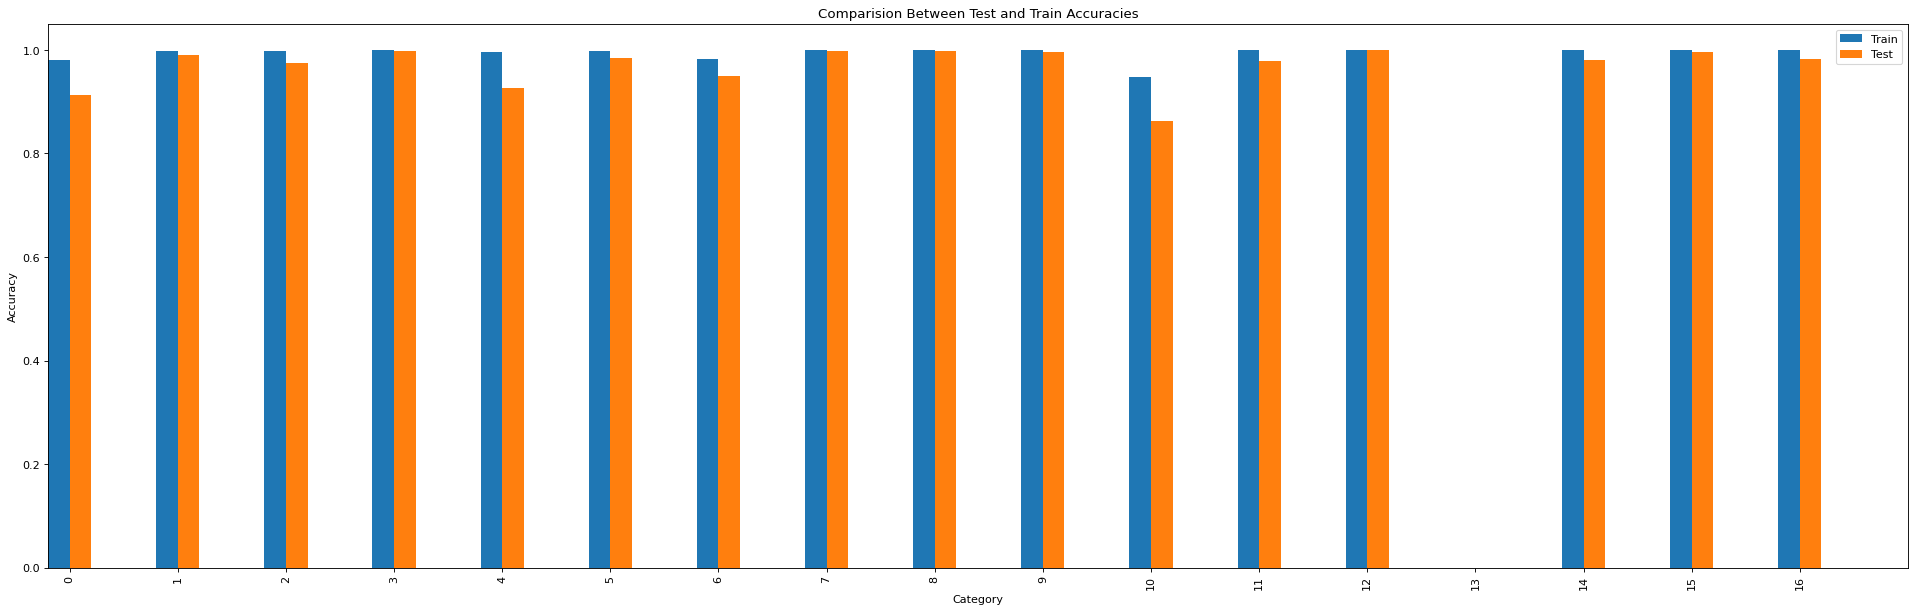

In [19]:
app_classes = [i for i in range(max(app_classes) + 1)]
print(app_classes)
analyse(model, app_train_loader, app_test_loader, app_classes)